In [1]:
import os, sys, random, math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import torch_utils
from tqdm.notebook import tqdm_notebook as tqdm
import time

font = {'size'   : 20}

matplotlib.rc('font', **font)

In [85]:
TRAIN_DF = pd.read_csv("./train.csv")
TEST_DF = pd.read_csv("./test.csv")
SUB_DF = pd.read_csv("./sample_submission.csv")

In [86]:
torch_utils.resumetable(TRAIN_DF)

Dataset Shape: (600000, 25)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,600000,0,1,2,19.19
1,bin_0,float64,17894,2,0,1,0,0.44
2,bin_1,float64,18003,2,0,1,1,0.69
3,bin_2,float64,17930,2,0,0,0,0.85
4,bin_3,object,18014,2,F,F,F,0.95
5,bin_4,object,18047,2,N,Y,N,1.00
6,nom_0,object,18252,3,Red,Red,Red,1.31
7,nom_1,object,18156,6,Trapezoid,Star,NaN,2.27
8,nom_2,object,18035,6,Hamster,Axolotl,Hamster,2.27
9,nom_3,object,18121,6,Russia,NaN,Canada,2.27


In [87]:
torch_utils.resumetable(TEST_DF)

Dataset Shape: (400000, 24)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,400000,600000,600001,600002,18.61
1,bin_0,float64,11901,2,0,0,0,0.45
2,bin_1,float64,12038,2,0,0,0,0.70
3,bin_2,float64,11972,2,0,0,0,0.85
4,bin_3,object,11951,2,F,F,F,0.95
5,bin_4,object,11951,2,Y,Y,Y,1.00
6,nom_0,object,12062,3,Blue,Red,Blue,1.31
7,nom_1,object,11947,6,Polygon,Circle,Circle,2.27
8,nom_2,object,12179,6,Axolotl,Lion,Axolotl,2.27
9,nom_3,object,12176,6,Finland,Russia,Russia,2.27


<Figure size 432x288 with 0 Axes>

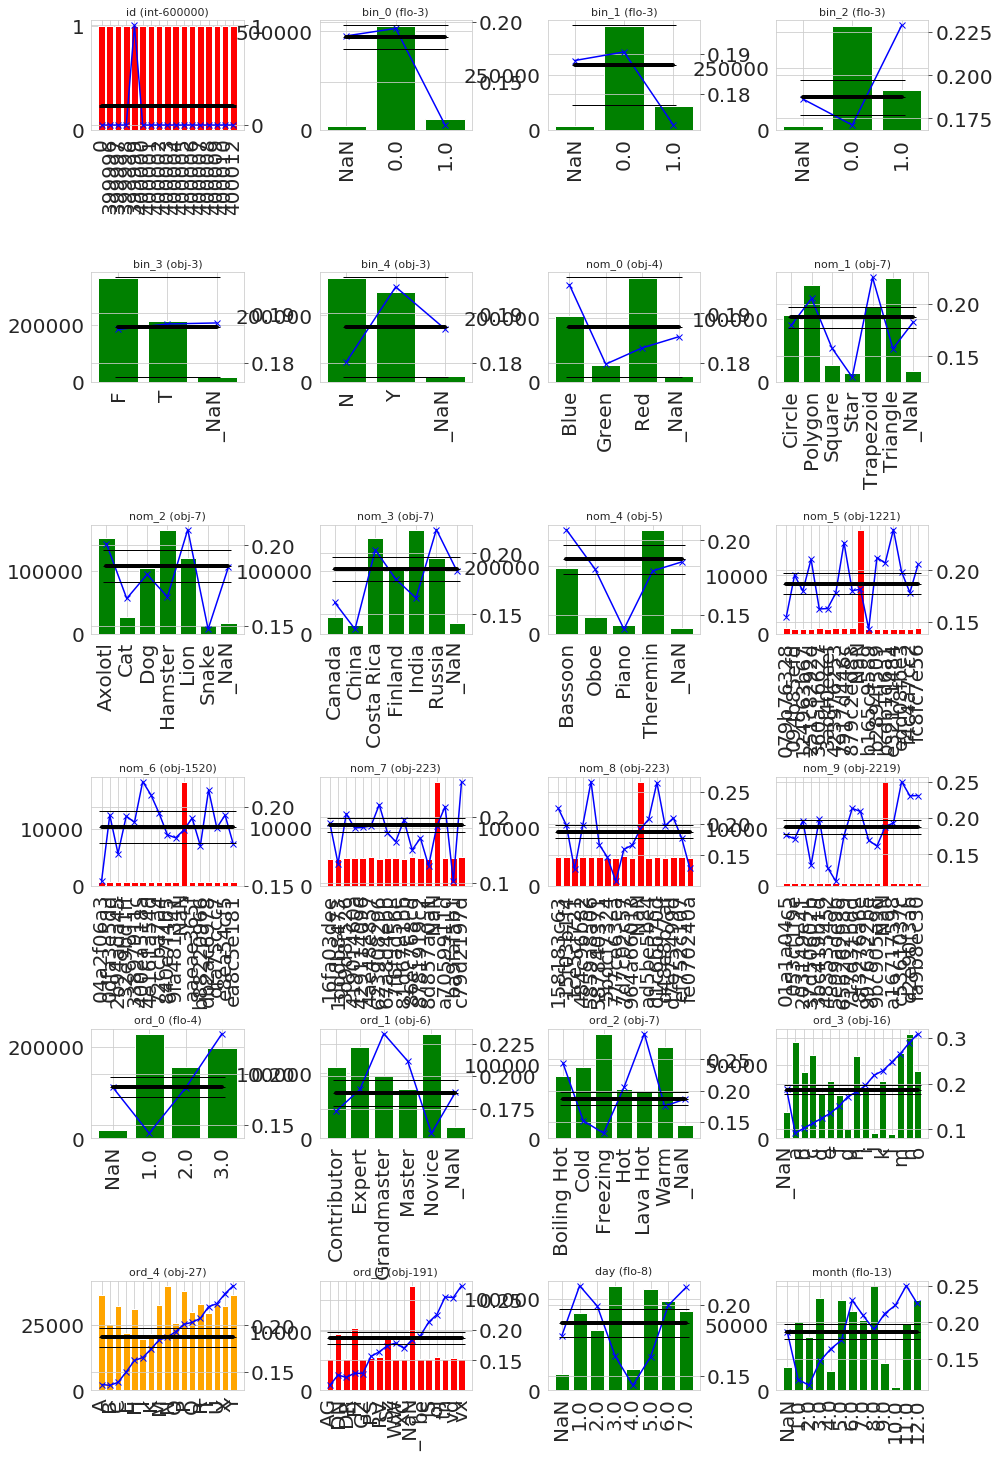

In [88]:
torch_utils.plot_multiple_categorical(TRAIN_DF,[v for v in list(TRAIN_DF.columns) if v not in ["target"]], "target", top_n=17)

In [103]:
TRAIN_DF = TRAIN_DF.fillna("NA")
TEST_DF = TEST_DF.fillna("NA")

In [104]:
TRAIN_DF.isnull().sum()

id        0
bin_0     0
bin_1     0
bin_2     0
bin_3     0
bin_4     0
nom_0     0
nom_1     0
nom_2     0
nom_3     0
nom_4     0
nom_5     0
nom_6     0
nom_7     0
nom_8     0
nom_9     0
ord_0     0
ord_1     0
ord_2     0
ord_3     0
ord_4     0
ord_5     0
day       0
month     0
target    0
dtype: int64

In [108]:
test_all = TEST_DF.copy(deep=True)
train_all = TRAIN_DF.drop(["target"], axis=1)

print(test_all.isnull().sum())
print(train_all.isnull().sum())

id       0
bin_0    0
bin_1    0
bin_2    0
bin_3    0
bin_4    0
nom_0    0
nom_1    0
nom_2    0
nom_3    0
nom_4    0
nom_5    0
nom_6    0
nom_7    0
nom_8    0
nom_9    0
ord_0    0
ord_1    0
ord_2    0
ord_3    0
ord_4    0
ord_5    0
day      0
month    0
dtype: int64
id       0
bin_0    0
bin_1    0
bin_2    0
bin_3    0
bin_4    0
nom_0    0
nom_1    0
nom_2    0
nom_3    0
nom_4    0
nom_5    0
nom_6    0
nom_7    0
nom_8    0
nom_9    0
ord_0    0
ord_1    0
ord_2    0
ord_3    0
ord_4    0
ord_5    0
day      0
month    0
dtype: int64


In [121]:
train_all = TRAIN_DF.drop(["target"], axis=1)

In [116]:
test_all = TEST_DF.copy(deep=True)
train_all = TRAIN_DF.drop(["target"], axis=1)
target = TRAIN_DF["target"]
train_test = pd.concat([train_all, test_all])


le = pp.LabelEncoder()

for col in list(train_all.columns):
    print(col)
    train_test[col] = train_test[col].astype("str")
    le.fit(train_test[col])
    train_test[col] = le.transform(train_test[col])

impute = pp.Imputer(strategy="most_frequent")


impute = impute.fit(train_test)
train_test = impute.transform(train_test)

id
bin_0
bin_1
bin_2
bin_3
bin_4
nom_0
nom_1
nom_2
nom_3
nom_4
nom_5
nom_6
nom_7
nom_8
nom_9
ord_0
ord_1
ord_2
ord_3
ord_4
ord_5
day
month


/home/numan947/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [117]:
ohe = pp.OneHotEncoder(handle_unknown="ignore")
ohe.fit(train_test)
train_test = ohe.transform(train_test)

In [124]:
train_all = train_test[:train_all.shape[0]]
test_all = train_test[train_all.shape[0]:]

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [126]:
lr = LogisticRegression(C=0.123456789,)

lr.fit(tt,target)

/home/numan947/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.123456789, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [129]:
%%time
rf = RandomForestClassifier(n_estimators=222, min_samples_leaf=10, verbose=2, n_jobs=5)
rf.fit(tt, target)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 222
building tree 2 of 222
building tree 3 of 222
building tree 4 of 222
building tree 5 of 222
building tree 6 of 222
building tree 7 of 222
building tree 8 of 222
building tree 9 of 222
building tree 10 of 222
building tree 11 of 222
building tree 12 of 222
building tree 13 of 222
building tree 14 of 222
building tree 15 of 222
building tree 16 of 222
building tree 17 of 222
building tree 18 of 222
building tree 19 of 222
building tree 20 of 222
building tree 21 of 222
building tree 22 of 222
building tree 23 of 222
building tree 24 of 222
building tree 25 of 222
building tree 26 of 222
building tree 27 of 222
building tree 28 of 222
building tree 29 of 222
building tree 30 of 222
building tree 31 of 222
building tree 32 of 222
building tree 33 of 222
building tree 34 of 222
building tree 35 of 222


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   39.1s


building tree 36 of 222
building tree 37 of 222
building tree 38 of 222
building tree 39 of 222
building tree 40 of 222
building tree 41 of 222
building tree 42 of 222
building tree 43 of 222
building tree 44 of 222
building tree 45 of 222
building tree 46 of 222
building tree 47 of 222
building tree 48 of 222
building tree 49 of 222
building tree 50 of 222
building tree 51 of 222
building tree 52 of 222
building tree 53 of 222
building tree 54 of 222
building tree 55 of 222
building tree 56 of 222
building tree 57 of 222
building tree 58 of 222
building tree 59 of 222
building tree 60 of 222
building tree 61 of 222
building tree 62 of 222
building tree 63 of 222
building tree 64 of 222
building tree 65 of 222
building tree 66 of 222
building tree 67 of 222
building tree 68 of 222
building tree 69 of 222
building tree 70 of 222
building tree 71 of 222
building tree 72 of 222
building tree 73 of 222
building tree 74 of 222
building tree 75 of 222
building tree 76 of 222
building tree 77

[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  2.9min


building tree 158 of 222
building tree 159 of 222
building tree 160 of 222
building tree 161 of 222
building tree 162 of 222
building tree 163 of 222
building tree 164 of 222
building tree 165 of 222
building tree 166 of 222
building tree 167 of 222
building tree 168 of 222
building tree 169 of 222
building tree 170 of 222
building tree 171 of 222
building tree 172 of 222
building tree 173 of 222
building tree 174 of 222
building tree 175 of 222
building tree 176 of 222
building tree 177 of 222
building tree 178 of 222
building tree 179 of 222
building tree 180 of 222
building tree 181 of 222
building tree 182 of 222
building tree 183 of 222
building tree 184 of 222
building tree 185 of 222
building tree 186 of 222
building tree 187 of 222
building tree 188 of 222
building tree 189 of 222
building tree 190 of 222
building tree 191 of 222
building tree 192 of 222
building tree 193 of 222
building tree 194 of 222
building tree 195 of 222
building tree 196 of 222
building tree 197 of 222


[Parallel(n_jobs=5)]: Done 222 out of 222 | elapsed:  4.2min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=222, n_jobs=5,
                       oob_score=False, random_state=None, verbose=2,
                       warm_start=False)

In [128]:
y_pred = lr.predict(tt)
print(metrics.roc_auc_score(target, y_pred))
y_test = lr.predict_proba(ts)
SUB_DF.target=pd.Series(y_test[:,1])
SUB_DF.to_csv("ALL_BAD_SUBMISSION_LR.csv", index=False)

0.5005249578762473


In [130]:
y_pred = rf.predict(tt)
print(metrics.roc_auc_score(target, y_pred))
y_test = rf.predict_proba(ts)
SUB_DF.target=pd.Series(y_test[:,1])
SUB_DF.to_csv("ALL_BAD_SUBMISSION_RF.csv", index=False)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    8.5s
[Parallel(n_jobs=5)]: Done 222 out of 222 | elapsed:   12.5s finished


0.501861351540016


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 222 out of 222 | elapsed:    9.9s finished
